In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/external-data-toxic-comments/ext_data.csv
/kaggle/input/new-data-upload/train_y.csv
/kaggle/input/new-data-upload/train_x.csv
/kaggle/input/new-data-upload/test_x.csv
/kaggle/input/new-data-upload/val_x.csv
/kaggle/input/new-data-upload/val_y.csv
/kaggle/input/embeddings/fasttext_embedding_matrix.npy
/kaggle/input/embeddings/glove_embedding_matrix.npy


In [2]:
train_x = pd.read_csv('/kaggle/input/new-data-upload/train_x.csv')
train_y = pd.read_csv('/kaggle/input/new-data-upload/train_y.csv')
train_data = train_x.join(train_y)

val_x = pd.read_csv('/kaggle/input/new-data-upload/val_x.csv')
val_y = pd.read_csv('/kaggle/input/new-data-upload/val_y.csv')
val_data = val_x.join(val_y)

External Toxic comments are sourced from https://www.kaggle.com/competitions/jigsaw-toxic-comment-classification-challenge/data

And using our BERT model trained on our competition data, Predicted the identities for these external comments and used this generated dataset as external data

In [3]:
ext_data = pd.read_csv('/kaggle/input/external-data-toxic-comments/ext_data.csv')

In [4]:
ext_data = ext_data.rename(columns = {
    
    'other_religion' : 'other_religions'
})

req_Cols = ['string', 'male', 'female', 'LGBTQ', 'christian', 'muslim',
       'other_religions', 'black', 'white', 'y']

train_data = train_data[req_Cols]
val_data = val_data[req_Cols]

train_data = pd.concat([train_data , ext_data], ignore_index = True)

In [5]:
train_data

,string,male,female,LGBTQ,christian,muslim,other_religions,black,white,y
0,even up here.......BLACKS!,0,0,0,0,0,0,1,0,1
1,Blame men. There's always an excuse to blame ...,1,1,0,0,0,0,0,0,1
2,You have no business making any comments on th...,0,0,0,0,0,0,0,0,1
3,"""Let's get the black folks and the white folks...",0,0,0,0,0,0,1,1,1
4,I guess the issue is people not willing to put...,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
329121,The Conservative economics of expanded trade h...,0,0,0,0,0,0,0,1,0
329122,So when white supremacists erect confederate s...,0,0,0,0,0,0,0,1,0
329123,"It really wasn't about the niqab, was it? It w...",0,0,0,0,1,0,0,0,0
329124,It is of course normal and natural for Eugene ...,0,0,0,0,0,0,0,1,0


In [6]:
identities = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']

### Preprocessing

In [7]:
import re
import string

misspell_dict = {"aren't": "are not", "can't": "cannot", "couldn't": "could not",
                 "didn't": "did not", "doesn't": "does not", "don't": "do not",
                 "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                 "he'd": "he would", "he'll": "he will", "he's": "he is",
                 "i'd": "I had", "i'll": "I will", "i'm": "I am", "isn't": "is not",
                 "it's": "it is", "it'll": "it will", "i've": "I have", "let's": "let us",
                 "mightn't": "might not", "mustn't": "must not", "shan't": "shall not",
                 "she'd": "she would", "she'll": "she will", "she's": "she is",
                 "shouldn't": "should not", "that's": "that is", "there's": "there is",
                 "they'd": "they would", "they'll": "they will", "they're": "they are",
                 "they've": "they have", "we'd": "we would", "we're": "we are",
                 "weren't": "were not", "we've": "we have", "what'll": "what will",
                 "what're": "what are", "what's": "what is", "what've": "what have",
                 "where's": "where is", "who'd": "who would", "who'll": "who will",
                 "who're": "who are", "who's": "who is", "who've": "who have",
                 "won't": "will not", "wouldn't": "would not", "you'd": "you would",
                 "you'll": "you will", "you're": "you are", "you've": "you have",
                 "'re": " are", "wasn't": "was not", "we'll": " will", "tryin'": "trying"}


In [8]:
puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']


In [9]:
def _get_misspell(misspell_dict):
    misspell_re = re.compile('(%s)' % '|'.join(misspell_dict.keys()))
    return misspell_dict, misspell_re


def replace_typical_misspell(text):
    misspellings, misspellings_re = _get_misspell(misspell_dict)

    def replace(match):
        return misspellings[match.group(0)]

    return misspellings_re.sub(replace, text)


def clean_text(x):
    x = str(x)
    for punct in puncts + list(string.punctuation):
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x


def clean_numbers(x):
    return re.sub(r'\d+', ' ', x)


def preprocess(text):
    text = str(text).lower()
    text = replace_typical_misspell(text)
    text = clean_text(text)
    text = clean_numbers(text)
    text = text.strip()
    return text

In [10]:
test_data = pd.read_csv('/kaggle/input/new-data-upload/test_x.csv')

In [11]:
train_data['string'] = train_data['string'].apply(preprocess)
val_data['string'] = val_data['string'].apply(preprocess)
test_data['string'] = test_data['string'].apply(preprocess)


Adding Weights

In [12]:
data = []

# Iterate through each identity
for identity in identities:
    # Calculate the count of toxic instances for this identity
    toxic_count = train_data[(train_data[identity] > 0.5) & (train_data['y'] == 1)].shape[0]
    
    # Calculate the count of non-toxic instances for this identity
    non_toxic_count = train_data[(train_data[identity] > 0.5) & (train_data['y'] == 0)].shape[0]
    
    total_count = train_data[(train_data[identity] > 0.5)].shape[0]
    
    # Append the counts to your data list
    data.append([identity, toxic_count, non_toxic_count, total_count])

# Create a DataFrame from your data
summary_df_train = pd.DataFrame(data, columns=['Identity', 'Toxic_Count', 'Non_Toxic_Count' , 'Total_Count'])
summary_df_train['difference'] = summary_df_train['Non_Toxic_Count'] - summary_df_train['Toxic_Count'] 

summary_df_train['difference_weight'] = summary_df_train['Total_Count']/summary_df_train['difference']



In [13]:
summary_df_train

,Identity,Toxic_Count,Non_Toxic_Count,Total_Count,difference,difference_weight
0,male,6053,32133,38186,26080,1.464187
1,female,6117,36905,43022,30788,1.397363
2,LGBTQ,4270,14383,18653,10113,1.844458
3,christian,3324,29516,32840,26192,1.253818
4,muslim,6099,27521,33620,21422,1.569415
5,other_religions,1006,5557,6563,4551,1.442101
6,black,6190,17575,23765,11385,2.087396
7,white,9342,31208,40550,21866,1.854477


### Why did I choose the difference as a weigting factor? 

- When the model was trained on BCE Loss, for every identity group, it was observed that the False Negatives were more. 
- This is expected as the number of *Non-Toxic* examples are higher. Model can be biased to predict a Toxic example as Non-Toxic. 
- But, I observed a pattern in worst performing groups. If the difference in Non toxic and toxic examples in a group is smaller, the total accuracy for the group is lower. 
- A smaller difference indicates a relatively balanced dataset for that group, which might mean the model doesn't learn enough distinguishing features for the Toxic class due to fewer examples. So ideally we should penalize the model for misclassification in these toxic examples.
- From the table we can see that black, white, LGBTQ, and muslim are the groups with relative lowest difference. These were the groups in the exact order that were performing poorly. 
- So, weighing based on this idea made much more sense. 

In [14]:
mask_male_toxic = (train_data['male'] > 0.5) & (train_data['y'] == 1)
mask_female_toxic = (train_data['female'] > 0.5) & (train_data['y'] == 1)
mask_LGBTQ_toxic = (train_data['LGBTQ'] > 0.5) & (train_data['y'] == 1)
mask_christian_toxic = (train_data['christian'] > 0.5) & (train_data['y'] == 1)
mask_muslim_toxic = (train_data['muslim'] > 0.5) & (train_data['y'] == 1)
mask_other_religions_toxic = (train_data['other_religions'] > 0.5) & (train_data['y'] == 1)
mask_black_toxic = (train_data['black'] > 0.5) & (train_data['y'] == 1)
mask_white_toxic = (train_data['white'] > 0.5) & (train_data['y'] == 1)

In [15]:
summary_df = summary_df_train

In [16]:
train_data['weights'] = 1
train_data.loc[mask_LGBTQ_toxic, 'weights'] += summary_df[summary_df['Identity'] == 'LGBTQ']['difference_weight'].values[0]
train_data.loc[mask_muslim_toxic, 'weights'] += summary_df[summary_df['Identity'] == 'muslim']['difference_weight'].values[0]
train_data.loc[mask_black_toxic, 'weights'] += (summary_df[summary_df['Identity'] == 'black']['difference_weight'].values[0])*2
train_data.loc[mask_white_toxic, 'weights'] += (summary_df[summary_df['Identity'] == 'white']['difference_weight'].values[0])*2

/tmp/ipykernel_34/4156199664.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.84445763 2.84445763 2.84445763 ... 2.84445763 2.84445763 2.84445763]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train_data.loc[mask_LGBTQ_toxic, 'weights'] += summary_df[summary_df['Identity'] == 'LGBTQ']['difference_weight'].values[0]


In [17]:
train_data

,string,male,female,LGBTQ,christian,muslim,other_religions,black,white,y,weights
0,even up here . . . . . . . ...,0,0,0,0,0,0,1,0,1,5.174791
1,blame men . there is always an excuse to b...,1,1,0,0,0,0,0,0,1,1.000000
2,you have no business making any comments on th...,0,0,0,0,0,0,0,0,1,1.000000
3,""" let us get the black folks and the white fo...",0,0,0,0,0,0,1,1,1,8.883746
4,i guess the issue is people not willing to put...,0,0,0,0,0,0,0,0,1,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
329121,the conservative economics of expanded trade h...,0,0,0,0,0,0,0,1,0,1.000000
329122,so when white supremacists erect confederate s...,0,0,0,0,0,0,0,1,0,1.000000
329123,"it really was not about the niqab , was it ...",0,0,0,0,1,0,0,0,0,1.000000
329124,it is of course normal and natural for eugene ...,0,0,0,0,0,0,0,1,0,1.000000


In [18]:
val_data['weights'] = 1

Tokenizing and Embedding

In [19]:
X_train = train_data['string'].fillna('_##_').values
X_test = test_data['string'].fillna('_##_').values
X_VAL = val_data['string'].fillna('_##_').values

In [20]:
from itertools import chain
max_features = 100000
from collections import Counter


def build_vocab(texts, max_features):
    counter = Counter()
    for text in texts:
        counter.update(text.split())

    vocab = {
        'token2id': {'<PAD>': 0, '<UNK>': max_features + 1},
        'id2token': {}
    }
    vocab['token2id'].update(
        {token: _id + 1 for _id, (token, count) in
         enumerate(counter.most_common(max_features))})
    vocab['id2token'] = {v: k for k, v in vocab['token2id'].items()}
    return vocab

def tokenize(texts, vocab, max_len):
    pad_id = vocab['token2id']['<PAD>']  # ID for the <PAD> token
    unk_id = vocab['token2id']['<UNK>']  # ID for the <UNK> token

    def text2ids(text, token2id):
        # Convert text to IDs, using <UNK> ID if the token isn't found
        token_ids = [token2id.get(token, unk_id) for token in text.split()[:max_len]]
        
        # Pad the sequences to the maximum length
        token_ids += [pad_id] * (max_len - len(token_ids))
        return token_ids
    
    return [text2ids(text, vocab['token2id']) for text in texts]

In [21]:
vocab = build_vocab(chain(X_train, X_test, X_VAL), max_features)

Load your embeddings and save them as .npy embedding matrix for future use. 

In [ ]:
#Load embeddings
#EMBEDDING_FASTTEXT = r'C:\Users\kingr\Downloads\Deep Learning\Kaggle\crawl-300d-2M.vec'
#EMBEDDING_GLOVE = r'C:\Users\kingr\Downloads\Deep Learning\Kaggle\glove.840B.300d\glove.840B.300d.txt'

In [22]:
fasttext_embedding_matrix = np.load('/kaggle/input/embeddings/fasttext_embedding_matrix.npy')
glove_embedding_matrix = np.load('/kaggle/input/embeddings/glove_embedding_matrix.npy')

In [23]:
X_train = np.array(tokenize(X_train, vocab, max_len=220))
X_test = np.array(tokenize(X_test, vocab, max_len=220))
X_val = np.array(tokenize(X_VAL, vocab, max_len=220))

In [24]:
import torch
from torch import nn

In [25]:
subgroups_list = ['male', 'female', 'LGBTQ', 'christian', 'muslim',
       'other_religions', 'black', 'white']

train_subgroups = train_data[subgroups_list]

val_subgroups = val_data[subgroups_list]

In [26]:
from torch.utils.data import Dataset, DataLoader

class CommentDataset(Dataset):
    def __init__(self, comments, labels, weights, subgroups = None):
        self.comments = comments
        self.labels = labels
        self.subgroups = subgroups
        self.weights = weights

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = torch.tensor(self.comments[idx], dtype=torch.long)
        label = torch.tensor(self.labels.iloc[idx], dtype=torch.float)
        weights = torch.tensor(self.weights.iloc[idx], dtype = torch.float)
        
        if self.subgroups is not None:
            
            return comment, label, weights, torch.FloatTensor(self.subgroups.iloc[idx])
        else:
            return comment, label , weights

In [27]:
# Create datasets
train_dataset = CommentDataset(X_train, train_data['y'], train_data['weights'], train_subgroups)  # Assuming train_labels is defined
val_dataset = CommentDataset(X_val, val_data['y'], val_data['weights'], val_subgroups)  # Assuming val_labels is defined

# Create data loaders
batch_size = 32  # Define your batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [28]:
from typing import List

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [29]:
embed_size = 300
maxlen=220



class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)

        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0

        weight = torch.zeros(feature_dim, 1)
        nn.init.kaiming_uniform_(weight)
        self.weight = nn.Parameter(weight)

        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))

    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim),
            self.weight
        ).view(-1, step_dim)

        if self.bias:
            eij = eij + self.b

        eij = torch.tanh(eij)
        a = torch.exp(eij)

        if mask is not None:
            a = a * mask

        a = a / (torch.sum(a, 1, keepdim=True) + 1e-10)

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

class Attention_Net(nn.Module):
    def __init__(self, embedding_matrix: np.ndarray):
        super(Attention_Net, self).__init__()
        drp = 0.1
        self.embedding = nn.Embedding(*embedding_matrix.shape)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False

        self.embedding_dropout = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(embed_size, 128, bidirectional=True, batch_first=True)
        self.lstm2 = nn.GRU(128*2, 64, bidirectional=True, batch_first=True)

        self.attention_layer = Attention(128, maxlen)

        self.linear = nn.Linear(64*2 , 64)
        self.relu = nn.ReLU()
        self.out = nn.Linear(64, 1)

    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = torch.squeeze(torch.unsqueeze(h_embedding, 0))
        h_lstm, _ = self.lstm(h_embedding)
        h_lstm, _ = self.lstm2(h_lstm)
        h_lstm_atten = self.attention_layer(h_lstm)
        conc = self.relu(self.linear(h_lstm_atten))
        out = self.out(conc)
        return out

In [30]:
model = Attention_Net(embedding_matrix=glove_embedding_matrix).to('cuda')

In [31]:
data_indices= val_y.index
data_indices = list(data_indices)

from sklearn.metrics import accuracy_score

def worst_group_accuracy(prediction, y):
    """
        Compute the worst group accuracy, with the groups being defined by ['male', 'female', 'LGBTQ',
        'christian', 'muslim', 'other_religions', 'black', 'white'] for positive and negative toxicity.
        arguments:
            prediction [pandas.DataFrame]: dataframe with 2 columns (index and pred)
            y [pandas.DataFrame]: dataframe containing the metadata
        returns:
            wga [float]: worst group accuracy
    """
    y.loc[prediction.index, 'pred'] = prediction.pred

    categories = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
    accuracies = []
    for category in categories:
        for label in [0, 1]:
            group = y.loc[y[category] == label]
            group_accuracy = (group['y'] == (group['pred'] > 0.5)).mean()
            accuracies.append(group_accuracy)
    wga = np.min(accuracies)
    return wga, accuracies

In [32]:
import warnings

warnings.filterwarnings('ignore', category=FutureWarning)

In [33]:
from torch.optim import Adam
from torch import optim

lr=0.0005

#optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.000025)
# Define Loss and Optimizer
optimizer = Adam(model.parameters(), lr=lr)  # Adjust the learning rate as needed

#scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda epoch: 0.6 ** epoch)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model = model.to(device)

# Training the model
num_epochs = 20  # Define the number of epochs

from tqdm import tqdm

wga_best = 0
logs = {}

for epoch in range(num_epochs):
    
    #scheduler.step()
    model.train()
    total_loss = 0
    
    
    train_iterator = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', dynamic_ncols=True)
    
    for comments, labels, weights,subgroups in train_iterator:
        # Move data to GPU if available
        comments, labels, weights, subgroups = comments.to(device), labels.to(device), weights.to(device), subgroups.to(device)

        # Forward pass
        outputs = model(comments)
        loss = (F.binary_cross_entropy_with_logits(outputs, labels.unsqueeze(-1), reduction='none') * weights ).mean()
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
        train_iterator.set_postfix(loss=loss.item())

    # Calculate average loss over the epoch
    avg_loss = total_loss / len(train_loader)

    # Evaluate the model every epoch
    model.eval()
    
    val_iterator = tqdm(val_loader, desc='Validation', dynamic_ncols=True)
    
    with torch.no_grad():
        correct = 0
        total_val_loss = 0
        all_predictions = []
        for comments, labels, weights, subgroups in val_iterator:
            
            comments, labels, weights, subgroups = comments.to(device), labels.to(device), weights.to(device), subgroups.to(device)
            
            outputs = model(comments)
            
            val_loss = (F.binary_cross_entropy_with_logits(outputs, labels.unsqueeze(-1), reduction='none') ).mean()
            total_val_loss += val_loss.item()
            
            probs = torch.sigmoid(outputs)  # Convert logits to probabilities
            predicted_labels = (probs > 0.5).float()  # Convert probabilities to predicted class (0 or 1)
            
            all_predictions.append(predicted_labels.cpu().numpy())
            
            # Update the tqdm progress bar
            val_iterator.set_postfix(val_loss=val_loss / len(val_iterator))

        all_predictions = np.concatenate(all_predictions, axis=0)
        true_labels = np.array(val_data['y'])  
        accuracy = accuracy_score(true_labels, all_predictions)
        
        avg_val_loss = total_val_loss / len(val_loader)
        
        predictions_df = pd.DataFrame({
        'index': data_indices,  # This should align with the index of your 'y' DataFrame
        'pred': all_predictions.squeeze()  # Make sure this is a 1D array
            })
        
        wga, grp_acc = worst_group_accuracy(predictions_df, val_y)
        
        groups = ['male', 'female', 'LGBTQ', 'christian', 'muslim', 'other_religions', 'black', 'white']
        toxic_acc = grp_acc[::2]
        nontoxic_acc = grp_acc[1::2]

        # Create a DataFrame
        df = pd.DataFrame({'Identity': groups, 'Identity Not Present': toxic_acc, 'Identity Present': nontoxic_acc})
        
        
        if wga > wga_best:
            
            torch.save(model.state_dict(), 'lstm_weighted.pt')
            wga_best = wga
            best_preds = predictions_df
            
        logs[epoch+1] = [val_loss / len(val_loader), accuracy, wga]

        

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val_loss: {avg_val_loss}, Validation Accuracy: {accuracy}%, WGA: {wga}, WGA_best: {wga_best}')
    print(df)
# Save the model checkpoint
#torch.save(model.state_dict(), 'model2.ckpt')


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 80.89it/s, val_loss=tensor(0.0001, device='cuda:0')]    


Epoch [1/20], Train Loss: 0.4036, Val_loss: 0.22984404858101487, Validation Accuracy: 0.913966356795042%, WGA: 0.736682808716707, WGA_best: 0.736682808716707
          Identity  Identity Not Present  Identity Present
0             male              0.917704          0.882267
1           female              0.916974          0.893906
2            LGBTQ              0.918007          0.792725
3        christian              0.912848          0.923956
4           muslim              0.919364          0.803791
5  other_religions              0.915373          0.850913
6            black              0.920695          0.736683
7            white              0.923971          0.766306


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 82.16it/s, val_loss=tensor(0.0001, device='cuda:0')]    


Epoch [2/20], Train Loss: 0.3041, Val_loss: 0.20352300998382797, Validation Accuracy: 0.9213590084108012%, WGA: 0.7699757869249395, WGA_best: 0.7699757869249395
          Identity  Identity Not Present  Identity Present
0             male              0.924805          0.892130
1           female              0.924355          0.901375
2            LGBTQ              0.925257          0.804393
3        christian              0.920674          0.927473
4           muslim              0.926352          0.819431
5  other_religions              0.922388          0.875254
6            black              0.927104          0.769976
7            white              0.930211          0.790722


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 82.90it/s, val_loss=tensor(0.0001, device='cuda:0')]    


Epoch [3/20], Train Loss: 0.2666, Val_loss: 0.19590951677111026, Validation Accuracy: 0.9229747675962815%, WGA: 0.7857142857142857, WGA_best: 0.7857142857142857
          Identity  Identity Not Present  Identity Present
0             male              0.926314          0.894648
1           female              0.926137          0.901884
2            LGBTQ              0.926377          0.820865
3        christian              0.922053          0.931209
4           muslim              0.927420          0.832227
5  other_religions              0.924356          0.861055
6            black              0.928184          0.785714
7            white              0.931109          0.802930


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 82.27it/s, val_loss=tensor(9.0097e-05, device='cuda:0')]


Epoch [4/20], Train Loss: 0.2346, Val_loss: 0.19714650471243617, Validation Accuracy: 0.9241035856573705%, WGA: 0.8020581113801453, WGA_best: 0.8020581113801453
          Identity  Identity Not Present  Identity Present
0             male              0.927948          0.891501
1           female              0.927257          0.903072
2            LGBTQ              0.927269          0.829101
3        christian              0.923505          0.929451
4           muslim              0.928372          0.836967
5  other_religions              0.925374          0.867140
6            black              0.928736          0.802058
7            white              0.931770          0.810952


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 81.54it/s, val_loss=tensor(7.8942e-05, device='cuda:0')]


Epoch [5/20], Train Loss: 0.2012, Val_loss: 0.21105786035222887, Validation Accuracy: 0.9263612217795485%, WGA: 0.822639225181598, WGA_best: 0.822639225181598
          Identity  Identity Not Present  Identity Present
0             male              0.929556          0.899265
1           female              0.929522          0.905279
2            LGBTQ              0.929099          0.844200
3        christian              0.925745          0.931868
4           muslim              0.929673          0.858768
5  other_religions              0.927366          0.881339
6            black              0.930298          0.822639
7            white              0.932574          0.834670


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 81.96it/s, val_loss=tensor(3.4375e-05, device='cuda:0')]


Epoch [6/20], Train Loss: 0.1688, Val_loss: 0.21260994700889735, Validation Accuracy: 0.9288844621513944%, WGA: 0.8450363196125908, WGA_best: 0.8450363196125908
          Identity  Identity Not Present  Identity Present
0             male              0.931659          0.905352
1           female              0.932220          0.906637
2            LGBTQ              0.931272          0.857241
3        christian              0.927960          0.937143
4           muslim              0.931600          0.873460
5  other_religions              0.929809          0.887424
6            black              0.932067          0.845036
7            white              0.933826          0.855947


Validation: 100%|██████████| 1412/1412 [00:16<00:00, 83.16it/s, val_loss=tensor(6.3694e-05, device='cuda:0')]


Epoch [7/20], Train Loss: 0.1395, Val_loss: 0.2298552419953365, Validation Accuracy: 0.9265825586542717%, WGA: 0.8571428571428571, WGA_best: 0.8571428571428571
          Identity  Identity Not Present  Identity Present
0             male              0.929432          0.902413
1           female              0.930362          0.901375
2            LGBTQ              0.928527          0.868222
3        christian              0.925523          0.936044
4           muslim              0.928767          0.881991
5  other_religions              0.927366          0.891481
6            black              0.929218          0.857143
7            white              0.931180          0.858737


Validation: 100%|██████████| 1412/1412 [00:16<00:00, 83.16it/s, val_loss=tensor(3.8187e-05, device='cuda:0')]


Epoch [8/20], Train Loss: 0.1168, Val_loss: 0.2544946488879391, Validation Accuracy: 0.9275564409030544%, WGA: 0.8680387409200968, WGA_best: 0.8680387409200968
          Identity  Identity Not Present  Identity Present
0             male              0.930818          0.899895
1           female              0.931406          0.901884
2            LGBTQ              0.929259          0.876458
3        christian              0.926286          0.938901
4           muslim              0.929278          0.892417
5  other_religions              0.928203          0.898580
6            black              0.929815          0.868039
7            white              0.931203          0.873736


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 80.68it/s, val_loss=tensor(3.4479e-05, device='cuda:0')]


Epoch [9/20], Train Loss: 0.1000, Val_loss: 0.278687502368912, Validation Accuracy: 0.9298583444001771%, WGA: 0.8710653753026635, WGA_best: 0.8710653753026635
          Identity  Identity Not Present  Identity Present
0             male              0.933267          0.900944
1           female              0.933671          0.904430
2            LGBTQ              0.931386          0.884008
3        christian              0.928747          0.939780
4           muslim              0.931530          0.895735
5  other_religions              0.930601          0.896552
6            black              0.932090          0.871065
7            white              0.933236          0.880014


Validation: 100%|██████████| 1412/1412 [00:16<00:00, 83.73it/s, val_loss=tensor(1.4470e-05, device='cuda:0')]


Epoch [10/20], Train Loss: 0.0881, Val_loss: 0.31233891233277356, Validation Accuracy: 0.9268038955289951%, WGA: 0.8746973365617433, WGA_best: 0.8746973365617433
          Identity  Identity Not Present  Identity Present
0             male              0.929803          0.901364
1           female              0.931278          0.896961
2            LGBTQ              0.928116          0.887440
3        christian              0.925745          0.936264
4           muslim              0.928187          0.898578
5  other_religions              0.927660          0.888438
6            black              0.928781          0.874697
7            white              0.929478          0.887339


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 81.28it/s, val_loss=tensor(2.2375e-05, device='cuda:0')]


Epoch [11/20], Train Loss: 0.0789, Val_loss: 0.32289783825920315, Validation Accuracy: 0.9286409915891988%, WGA: 0.8746973365617433, WGA_best: 0.8746973365617433
          Identity  Identity Not Present  Identity Present
0             male              0.931783          0.901994
1           female              0.933315          0.897471
2            LGBTQ              0.929991          0.888126
3        christian              0.927664          0.937363
4           muslim              0.929928          0.902370
5  other_religions              0.929153          0.905680
6            black              0.930688          0.874697
7            white              0.931321          0.889083


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 82.70it/s, val_loss=tensor(1.9962e-05, device='cuda:0')]


Epoch [12/20], Train Loss: 0.0728, Val_loss: 0.3516263837491995, Validation Accuracy: 0.9271801682160248%, WGA: 0.8819612590799032, WGA_best: 0.8819612590799032
          Identity  Identity Not Present  Identity Present
0             male              0.930496          0.899056
1           female              0.931075          0.901205
2            LGBTQ              0.928642          0.883322
3        christian              0.926286          0.935165
4           muslim              0.928442          0.901422
5  other_religions              0.927796          0.899594
6            black              0.928896          0.881961
7            white              0.929643          0.890827


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 81.93it/s, val_loss=tensor(5.1616e-05, device='cuda:0')]


Epoch [13/20], Train Loss: 0.0678, Val_loss: 0.3620345876915035, Validation Accuracy: 0.9239043824701195%, WGA: 0.8825665859564165, WGA_best: 0.8825665859564165
          Identity  Identity Not Present  Identity Present
0             male              0.926686          0.900315
1           female              0.928250          0.894924
2            LGBTQ              0.925234          0.884008
3        christian              0.922889          0.932967
4           muslim              0.924797          0.905687
5  other_religions              0.924605          0.892495
6            black              0.925473          0.882567
7            white              0.926287          0.888734


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 81.57it/s, val_loss=tensor(4.4751e-05, device='cuda:0')]


Epoch [14/20], Train Loss: 0.0625, Val_loss: 0.37627399460573235, Validation Accuracy: 0.9266710934041611%, WGA: 0.8813559322033898, WGA_best: 0.8825665859564165
          Identity  Identity Not Present  Identity Present
0             male              0.929457          0.903043
1           female              0.930973          0.897980
2            LGBTQ              0.927978          0.887440
3        christian              0.925252          0.939341
4           muslim              0.927815          0.903318
5  other_religions              0.927162          0.904665
6            black              0.928391          0.881356
7            white              0.928958          0.892919


Validation: 100%|██████████| 1412/1412 [00:16<00:00, 83.59it/s, val_loss=tensor(3.5389e-05, device='cuda:0')]


Epoch [15/20], Train Loss: 0.0600, Val_loss: 0.3914364271299476, Validation Accuracy: 0.9269809650287738%, WGA: 0.8843825665859564, WGA_best: 0.8843825665859564
          Identity  Identity Not Present  Identity Present
0             male              0.929976          0.901574
1           female              0.931533          0.896622
2            LGBTQ              0.928253          0.888813
3        christian              0.925892          0.936703
4           muslim              0.927885          0.908531
5  other_religions              0.927569          0.900609
6            black              0.928598          0.884383
7            white              0.929289          0.892919


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 81.75it/s, val_loss=tensor(2.2070e-05, device='cuda:0')]


Epoch [16/20], Train Loss: 0.0574, Val_loss: 0.40683376876817584, Validation Accuracy: 0.9287295263390881%, WGA: 0.8849878934624698, WGA_best: 0.8849878934624698
          Identity  Identity Not Present  Identity Present
0             male              0.932080          0.900315
1           female              0.933340          0.897980
2            LGBTQ              0.930151          0.886067
3        christian              0.927689          0.938022
4           muslim              0.929742          0.908057
5  other_religions              0.929493          0.894523
6            black              0.930390          0.884988
7            white              0.931416          0.889083


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 81.84it/s, val_loss=tensor(2.4462e-05, device='cuda:0')]


Epoch [17/20], Train Loss: 0.0543, Val_loss: 0.4199802322541221, Validation Accuracy: 0.9279548472775564%, WGA: 0.8819492107069321, WGA_best: 0.8849878934624698
          Identity  Identity Not Present  Identity Present
0             male              0.930570          0.905771
1           female              0.931838          0.902054
2            LGBTQ              0.929488          0.881949
3        christian              0.926926          0.937143
4           muslim              0.928814          0.910427
5  other_religions              0.928497          0.903651
6            black              0.929700          0.881961
7            white              0.930281          0.893617


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 81.16it/s, val_loss=tensor(1.7042e-05, device='cuda:0')]


Epoch [18/20], Train Loss: 0.0528, Val_loss: 0.41103755344525655, Validation Accuracy: 0.9300575475874281%, WGA: 0.8789346246973365, WGA_best: 0.8849878934624698
          Identity  Identity Not Present  Identity Present
0             male              0.932797          0.906821
1           female              0.933951          0.904091
2            LGBTQ              0.931340          0.891558
3        christian              0.929018          0.939341
4           muslim              0.931205          0.906635
5  other_religions              0.930624          0.904665
6            black              0.931998          0.878935
7            white              0.932928          0.887687


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 82.24it/s, val_loss=tensor(1.3952e-05, device='cuda:0')]


Epoch [19/20], Train Loss: 0.0502, Val_loss: 0.4329080797906029, Validation Accuracy: 0.9269809650287738%, WGA: 0.8825665859564165, WGA_best: 0.8849878934624698
          Identity  Identity Not Present  Identity Present
0             male              0.930100          0.900525
1           female              0.931253          0.898489
2            LGBTQ              0.928093          0.893617
3        christian              0.925572          0.939560
4           muslim              0.928187          0.902370
5  other_religions              0.927682          0.895538
6            black              0.928667          0.882567
7            white              0.929431          0.890827


Validation: 100%|██████████| 1412/1412 [00:17<00:00, 82.49it/s, val_loss=tensor(1.5565e-05, device='cuda:0')]


Epoch [20/20], Train Loss: 0.0488, Val_loss: 0.4331037451704876, Validation Accuracy: 0.9276449756529438%, WGA: 0.8831719128329297, WGA_best: 0.8849878934624698
          Identity  Identity Not Present  Identity Present
0             male              0.930941          0.899685
1           female              0.932271          0.896792
2            LGBTQ              0.928825          0.892244
3        christian              0.926458          0.938242
4           muslim              0.928814          0.903791
5  other_religions              0.928271          0.899594
6            black              0.929333          0.883172
7            white              0.930163          0.890478


### Testing and Submission

In [36]:
from torch.utils.data import Dataset, DataLoader

class TestDataset(Dataset):
    def __init__(self, comments):
        self.comments = comments
        

    def __len__(self):
        return len(self.comments)

    def __getitem__(self, idx):
        comment = torch.tensor(self.comments[idx], dtype=torch.long)
        return comment

# Create datasets
test_dataset = TestDataset(X_test)  # Assuming train_labels is defined
# Create data loaders
batch_size = 32  # Define your batch size
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [66]:
model.eval()
test_predictions = []
with torch.no_grad():
    test_iterator = tqdm(test_loader, desc='Testing', dynamic_ncols=True)
    for comments in test_iterator:
        
        comments = comments.to(device)
            
        outputs = model(comments)

            
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        predicted_labels = (probs > 0.5).float()  # Convert probabilities to predicted class (0 or 1)

        test_predictions.append(predicted_labels.cpu().numpy())
                
    test_predictions = np.concatenate(test_predictions, axis=0)
    
    predictions_df = pd.DataFrame({
        'ID': list(test_data.index),  # This should align with the index of your 'y' DataFrame
        'pred': test_predictions.squeeze()  # Make sure this is a 1D array
            })
    

Testing: 100%|██████████| 4181/4181 [00:19<00:00, 211.26it/s]


In [67]:
test_data['preds'] = predictions_df['pred']

In [68]:
test_data

,index,string,preds
0,0,oh yes - were those evil christian mission...,0.0
1,1,he is considered a good candidate for a cyber ...,0.0
2,2,"lela , you admit no records exist to suppor...",0.0
3,3,I will take the iffy libertarian over the guy ...,1.0
4,4,should not your handle be republic of uranus ?,0.0
...,...,...,...
133777,133777,"is it better to be dead , and broke ? al...",0.0
133778,133778,"when you say speaking in code , you are add...",0.0
133779,133779,at least twice trained law enforcement officer...,1.0
133780,133780,"I have not said this before , but kizla you...",1.0


In [69]:
predictions_df.to_csv('weighted_lstm.csv' , index = False)

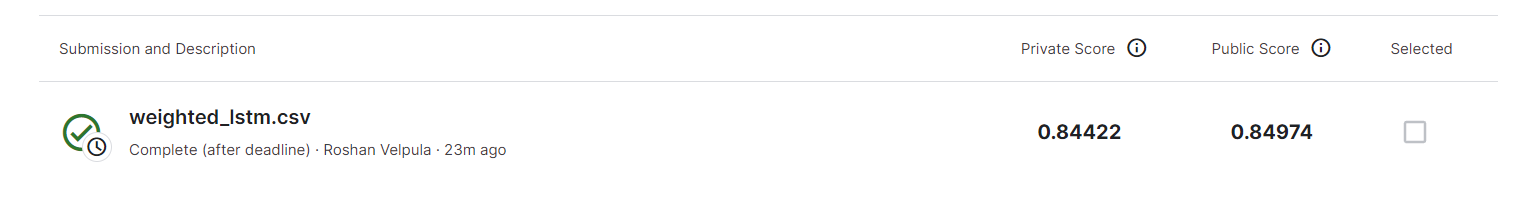

A score better than BERT? 